# Tutorial - ``params``, ``options``, and simulation

This series of tutorials is an introduction to ``respy`` for new users. It is especially targeted at Economics students 
taking their first steps in structural econometric modeling, and it also serves to showcase the potential of ``respy`` as a teaching tool. 

In this first tutorial we will learn how to specify and simulate a simple model with ``respy``. As economists love Robinsonades [<sup>1</sup>](#fn1), we will implement a simple Robinson Crusoe economy as a discrete choice dynamic programming model. 

In [1]:
%matplotlib inline

import io
import yaml
import pandas as pd
import respy as rp
import matplotlib.pyplot as plt
import seaborn as sns

## The model: a simple Robinson Crusoe economy

In this basic Robinson Crusoe economy, Robinson is alone on a desert island and must choose every period $t = \{0, 1, ... T-1\}$ between two alternatives: fishing or relaxing on his hammock. Each of the two alternatives is associated with a certain level of instantaneous utility, determined at each time $t$ by a deterministic component and a stochastic component. As Robinson cannot foresee these stochastic components, we speak of "choice under uncertainty".<br>

In ``respy`` the istantaneous utility of an alternative, $u_t$, consists of the sum of a pecuniary reward or wage $W_t$ and a non-pecuniary reward $N_t$.<br> 
Speaking of a wage in this context seems inappropriate since Robinson, being alone on an island, won't receive any wage for the time he spends fishing. However, this distinction is useful to keep in mind when tackling more complex models of labor supply.

The **wage** is zero if Robinson chooses to relax on his hammock. If Robinson goes fishing his wage at time $t$ is:

$$
W^f = exp\{x_t \beta^f + \epsilon_{ft}\}
$$

where:

- $f$ indicates the "fishing" alternative; 
- $x_t$ denotes Robinson's experience in fishing;
- $\beta^f$ denotes the return to experience in fishing; 
- $\epsilon_{ft}$ is a random shock.<br>

In words, the deterministic component of Robinson's wage is generated each day by only one covariate, his current experience in fishing (which is 0 if Robinson never fished before, 1 if Robinson fished once before, and so on), times the return to experience in fishing. The stochastic component, $\epsilon_{ft}$, is drawn from a Normal distribution, and (may) depend on the current time $t$ and on Robinson's current choice. 

The **non-pecuniary reward** for fishing and relaxing on the hammock are simply set as constant terms, with an additional shock, also drawn from a Normal distribution, entering the latter additively: 

$$\begin{align}
N^f = \alpha^f \\
N^h = \alpha^h + \epsilon_{ht}\
\end{align}$$

More generally, the wage and non-pecuniary rewards can be flexibly generated specifying a vector of choice- and time-dependent covariates and the associated vector of choice-dependent parameters. 

<div class="alert alert-info">

See [link to how-to guide] for a more detailed explaination of how to specify a model in ``respy``.

</div>

The parameters of this simple model are $\alpha^h$ and $\alpha^f$ (the constants in the non-pecuniary rewards) and $\beta^f$ (return to experience in fishing), along with the time-preference parameter (see below) and the lower triangular elements of the shocks variance-covariance matrix which governs the distribution of the shocks. 

## Solution

Discrete choice models are usually derived under an assumption of utility-maximizing behavior by the decision-maker. Indeed, below we assume that Robinson is forward-looking and that, in each period $t$, he wants to maximize the expected present value of utility over the remaining periods. However, Robinson can discount the utility stream derived from future periods in different ways. ``respy`` allows for:

- Exponential discounting
- Hyperbolic discounting (with a completely naïve agent)

In the following, we assume Robinson to be an exponential discounter. This means that Robinson's time preferences can be described by:

$$
U_t(u_t, u_{t+1}, ...) \equiv \sum_{t=0}^T{\delta^t u_t}
$$

where $\delta \in (0, 1]$  is the long-run discount factor which capture Robinson's preferences for immediate
over future gratification.<br> 
If $\delta=0$, then Robinson is completely myopic and at each time $t$ simply chooses the alternative associated with the highest instantaneous utility. If $\delta>0$, at each period $t$, Robinson doesn't compare levels of instantaneous utility
but *value functions* which incorporate the utility derived from future choices.<br>
Robinson's problem (choosing the optimal sequence of alternatives) can be solved with dynamic programming. 

<div class="alert alert-info">

See [link] for the tutorial on hyperbolic discounting, and [link to explanations] for more details on the solution of the model.

</div>

## Specification: ``params`` and ``options``

How can we express the model's equations and parameters with ``respy``? The parameters can be easily written to a .csv file and loaded with ``pandas``. The resulting DataFrame contains a two-level MultiIndex to group parameters (identified by a unique name and value) in categories. In particular:

- ``"delta"`` refers to Robinson's long-run discount factor;
- ``"wage_fishing"``groups the covariates and associated parameters appearing in the wage. Indeed, ``"exp_fishing"`` represents Robinson's experience in fishing (which is determined endogenously and recomputed from period to period) while the associated ``value`` is the return to experience;
- ``"nonpec_fishing"`` groups the covariates and associated parameters appearing in the non-pecuniary rewards, and therefore contains two constant terms. Note that in the example below we set ``"nonpec_fishing"`` to be negative, to reflect the effort cost of fishing, while ``"nonpec_hammock"`` is set as positive to reflect the good feeling of relaxing on the hammock.
- ``"shocks_sdcorr"`` groups the lower triangular elements of the shocks variance-covariance matrix. In ``respy``, shocks are allowed to be correlated across choices.

In [2]:
params = """
category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.07
nonpec_fishing,constant,-0.102
nonpec_hammock,constant,1.046
shocks_sdcorr,sd_fishing,0.01
shocks_sdcorr,sd_hammock,0.01
shocks_sdcorr,corr_hammock_fishing,0
"""

In [3]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.102
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

``params`` is complemented with ``options``, which need to be specified in the YAML format. ``options`` contain additional information needed for the solution, simulation and estimation of the model. For example, `"n_periods"` defines the number of periods for which the model is solved and simulated, and ``"simulation_agents"`` defines how many identical individuals are simulated. 

Note that the behavior across individuals can differ because each simulated individual faces a different sequence of shocks: Seeds (denoted by ``"_seed"``in the ``options``) are used in every model component to ensure reproducibility. You can use any seed you would like or even repeat the same seed number. Internally, we ensure that randomness is completely uncorrelated.

<div class="alert alert-info">

See [link] for more details on randomness and reproducibility in ``respy``.

</div>

In [4]:
options = """
{'solution_draws': 100,
 'solution_seed': 456,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'covariates': {'constant': '1'}}
"""

In [5]:
options = yaml.safe_load(io.StringIO(options))
options

{'solution_draws': 100,
 'solution_seed': 456,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'covariates': {'constant': '1'}}

## Simulation

We are now ready to simulate the model. Performing a simulation returns a MultiIndex containing all the information needed to inspect Robinson's decisions period by period. The visualizations below can be easily generated with the ``Matplotlib`` library.

<div class="alert alert-info">

See [link] for a guide on how to simulate with ``respy``.

</div>

In [6]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

In [7]:
df.head(10)

,Identifier,Period,Choice,Wage,Experience_Fishing,Type,Nonpecuniary_Reward_Fishing,Nonpecuniary_Reward_Hammock,Wage_Fishing,Flow_Utility_Fishing,Flow_Utility_Hammock,Value_Function_Fishing,Value_Function_Hammock,Shock_Reward_Fishing,Shock_Reward_Hammock,Discount_Rate
0,0,0,hammock,NaN,0,0,-0.102,1.046,1.0,0.905197,1.056305,4.738557,4.742931,1.007197,0.010305,0.95
1,0,1,hammock,NaN,0,0,-0.102,1.046,1.0,0.907392,1.046042,3.750101,3.880917,1.009392,0.000042,0.95
2,0,2,hammock,NaN,0,0,-0.102,1.046,1.0,0.909790,1.053231,2.847405,2.990846,1.011790,0.007231,0.95
3,0,3,hammock,NaN,0,0,-0.102,1.046,1.0,0.902414,1.048698,1.896152,2.042435,1.004414,0.002698,0.95
4,0,4,hammock,NaN,0,0,-0.102,1.046,1.0,0.874475,1.030870,0.874475,1.030870,0.976475,-0.015130,0.95
5,1,0,hammock,NaN,0,0,-0.102,1.046,1.0,0.879015,1.056596,4.712375,4.743221,0.981015,0.010596,0.95
6,1,1,hammock,NaN,0,0,-0.102,1.046,1.0,0.919590,1.039141,3.762299,3.874017,1.021590,-0.006859,0.95
7,1,2,hammock,NaN,0,0,-0.102,1.046,1.0,0.897238,1.052078,2.834852,2.989693,0.999238,0.006078,0.95
8,1,3,hammock,NaN,0,0,-0.102,1.046,1.0,0.891793,1.038037,1.885530,2.031775,0.993793,-0.007963,0.95
9,1,4,hammock,NaN,0,0,-0.102,1.046,1.0,0.910283,1.052177,0.910283,1.052177,1.012283,0.006177,0.95


In [8]:
def plot_robinson_choices(df):
    sns.set_style("white")
    sns.set_context("notebook", font_scale=1.5)

    fig, ax = plt.subplots(figsize=(8, 5))

    df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(stacked=True, ax=ax)
    plt.xticks(rotation="horizontal")
    plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.35), ncol=2)
    plt.title("Robinson's choices by period", pad=15)

    plt.show()

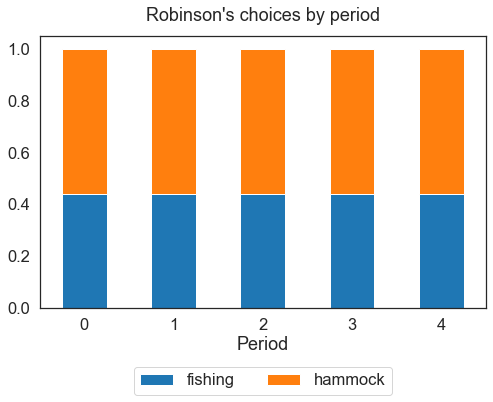

In [9]:
plot_robinson_choices(df)

A payoff of structural models is the possibility to simulate and analyse counterfactuals: As an example, in models of educational choice, the analysis of comparitive statics is often applied to evaluate the effect of alternative tuition policies on average educational attainment. 

How does Robinson's behavior change if we increase the return to experience in fishing? We can simulate the model again and inspect Robinson's new choices. 

In [10]:
params.loc[("wage_fishing","exp_fishing"),"value"] = 0.075

In [11]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

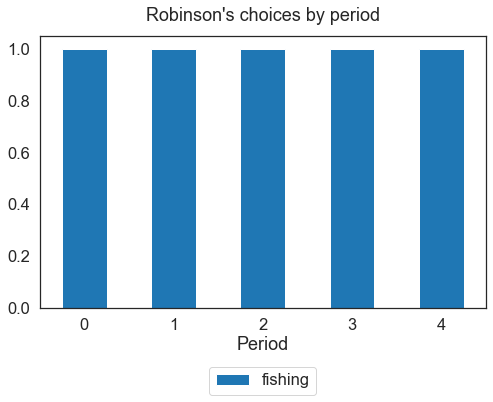

In [12]:
plot_robinson_choices(df)

In the next tutorials, we will showcase how to estimate the model parameters via maximum likelihood. Moreover, we will learn to enrich our simple Robinson Crusoe economy including more covariates and choices, as well as observed characteristics and exogenous processes.

***

**Footnotes**

<span id="fn1"><sup>1</sup>
    One of the earliest references of Robinsonades in Economics can be found in Marx (1867). In the 37th footnote, he mentions that even Ricardo used the theme before him.
</span>

## References

Marx, K. (1867). Das Kapital, Bd. 1. *MEW*, Bd, 23, 405